<a href="https://colab.research.google.com/github/rdgdelfino/MVP_MachineLearning_Churn/blob/main/MVP_MachineLearning_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise Preditiva de Churn (Cancelamento de Clientes)**

## **1. Definição do Problema**

### **1.1) Objetivo**
O objetivo deste modelo consiste em identificar e prever os clientes com maior probabilidade de cancelar os serviços de uma empresa de telecomunicações. A partir dessa análise, a organização poderá adotar estratégias de retenção mais eficazes, voltadas especificamente para os clientes com maior risco de evasão (churn), a fim de minimizar perdas e otimizar a alocação de recursos.

### **1.2) Descrição do Problema**
A retenção de clientes constitui uma preocupação essencial para as empresas, uma vez que o número de clientes está diretamente relacionado ao faturamento e que os custos associados à aquisição de novos usuários geralmente superam os custos de retenção dos clientes existentes. Torna-se, portanto, imprescindível compreender os padrões de comportamento dos clientes que encerram sua assinatura, a fim de mitigar futuros cancelamentos. Por meio de um modelo de Machine Learning, é possível identificar os clientes com maior propensão ao churn, permitindo que a empresa implemente ações de retenção direcionadas. Este configura-se como um problema de classificação, no qual, com base em dados históricos de clientes, é viável prever a tendência de cancelamento de novos clientes.
### **1.3) Premissa**
A premissa fundamental é que, ao analisar os comportamentos e características dos clientes que optaram pelo cancelamento (churn), é possível identificar padrões que contribuem para a previsão do comportamento de novos clientes. Essa análise permite a elaboração de campanhas de retenção personalizadas e mais eficazes, com foco na mitigação do churn e na fidelização dos clientes mais propensos a permanecer com os serviços.

### **1.4) Restrições ou Condições**
- O dataset é fictício, criado pela IBM para fins educacionais.
- Dados inconsistentes podem estar presentes, como valores de cobranças totais representados como strings (ao invés de valores numéricos).
- A qualidade dos dados e a presença de valores ausentes podem influenciar a precisão do modelo preditivo.

In [44]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.model_selection import StratifiedKFold # para executar a validação cruzada com estratificação
from sklearn.model_selection import GridSearchCV # para executar a otimização de hiperparâmetros

from sklearn.pipeline import Pipeline # para criação de pipelines

from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo
from sklearn.metrics import recall_score # para a exibição da acurácia do modelo
from sklearn.metrics import precision_score # para a exibição da precisão do modelo
from sklearn.metrics import f1_score # para a exibição o f1_score do modelo

from sklearn.preprocessing import MinMaxScaler # Normalização de variáveis numéricas
from sklearn.preprocessing import OneHotEncoder # Encoding de variáveis categórias para númericas

from sklearn.decomposition import PCA # para a redução de dimensionalidade

from sklearn.feature_selection import SelectKBest # para a Seleção Univariada
from sklearn.feature_selection import f_classif # para o teste ANOVA da Seleção Univariada

from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore de Classificação
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.svm import SVC # algoritmo SVM
from sklearn.ensemble import ExtraTreesClassifier # ExtraTrees, para a Importância de Atributos
from sklearn.linear_model import LogisticRegression # Regressão Logística

# para o usos de Ensembles
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb


from sklearn.metrics import classification_report # para visualização de resultados
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # para construção da Matrix de Confusão



## **1.5) Descrição do Dataset**

O dataset selecionado contém informações sobre os clientes de uma companhia de telecomunicações fictícia. Cada linha representa um cliente.


In [45]:
# Importando Dataset

df_churn = pd.read_csv("hf://datasets/scikit-learn/churn-prediction/dataset.csv")

### **Atributos Categóricos:**
- **CustomerID**: ID único que identifica cada cliente.
- **gender**: Gênero do cliente. (Binário: Male ou Female)
- **Partner**: Indica se o cliente tem um parceiro. (Binário: Sim ou Não)
- **Dependents**: Indica se o cliente tem dependentes. (Binário: Sim ou Não)
- **PhoneService**: Se o cliente possui telefone fixo. (Binário: Sim ou Não)
- **MultipleLines**: Se o cliente tem múltiplas linhas telefônicas. (Binário: Sim ou Não)
- **InternetService**: Tipo de serviço de internet contratado.
- **OnlineSecurity**: Se o cliente tem serviço de segurança online. (Binário: Sim ou Não)
- **OnlineBackup**: Se o cliente tem serviço de backup online. (Binário: Sim ou Não)
- **DeviceProtection**: Se o cliente tem proteção para dispositivos. (Binário: Sim ou Não)
- **TechSupport**: Se o cliente tem suporte técnico. (Binário: Sim ou Não)
- **StreamingTV**: Se o cliente usa a internet para assistir TV. (Binário: Sim ou Não)
- **StreamingMovies**: Se o cliente usa a internet para assistir filmes. (Binário: Sim ou Não)
- **Contract**: Tipo de contrato que o cliente possui.
- **PaperlessBilling**: Se o cliente opta por fatura digital. (Binário: Sim ou Não)
- **PaymentMethod**: Método de pagamento utilizado pelo cliente.
- **Churn**: Se o cliente cancelou o serviço. Variável alvo. (Binário: Sim ou Não)

### **Atributos Numéricos:**
- **SeniorCitizen**: Se o cliente é idoso (Binário: 0 ou 1).
- **tenure**: Número de meses que o cliente está com a empresa.
- **MonthlyCharges**: Valor total mensal que o cliente paga pelos serviços.
- **TotalCharges**: Total de cobranças acumuladas até o final do trimestre. Pode ser uma string devido a inconsistências nos dados, por exemplo, valores vazios podem ser representados como strings.


### **Objetivo de Classificação:**
- **Churn**: Variável de interesse que indica se o cliente cancelou ou não o serviço. O objetivo é prever essa variável com base nas outras características.


In [46]:
df_churn.head() # Exibição das 5 primeiras observações

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [47]:
df_churn.tail()  # Exibição das 5 últimas observações

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No



### **1.5.1) Limpeza e tratamento de valores faltantes**


O tratamento de dados é fundamental na modelagem, pois assegura que as informações sejam de qualidade, consistentes e relevantes. Esse processo envolve a limpeza, normalização e transformação dos dados, eliminando inconsistências e garantindo que o modelo gere resultados precisos e confiáveis. Dados bem tratados melhoram a acurácia e a performance do modelo, proporcionando previsões mais eficazes.


In [48]:
# Remoção do campo customerID por ser apenas um dado cadastral

df_churn = df_churn.drop('customerID', axis=1)

In [49]:
# Verificação de missing values e tipo de dado.

df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


Para iniciar a análise do dataset, é necessário verificar os tipos de dados das colunas e identificar os valores faltantes para posterior tratamento. Embora não haja valores nulos na variável **TotalCharges**, o tipo de dado incorreto, que não é numérico, pode sugerir a presença de caracteres nas observações. A variável **customerID**, sendo uma chave de identificação do cliente, não contribui para o modelo e pode ser desconsiderada.

In [50]:
# Conversão dos valores da coluna para numérico

df_churn['TotalCharges'] = pd.to_numeric(df_churn['TotalCharges'], errors='coerce')
print("O tipo da variável TotalCharges agora é %s" % df_churn['TotalCharges'].dtype)

O tipo da variável TotalCharges agora é float64


In [51]:
# Encontrar linhas com valores missing values

nan_rows = df_churn.isna().any(axis=1)
df_churn[nan_rows]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


O tratamento de valores nulos em um dataset é uma etapa crucial para garantir a qualidade e integridade dos dados. Valores nulos podem ocorrer por diversos motivos, como falhas na coleta ou registros incompletos. Existem várias abordagens para lidar com esses valores, como a imputação (substituição dos nulos por médias, medianas, ou valores mais frequentes), a exclusão de linhas ou colunas com muitos valores faltantes, ou a utilização de técnicas mais avançadas, como modelos preditivos para estimar os valores ausentes.

O dataset possui apenas 11 observações com valores faltantes para a variável TotalCharges. O tratamento escolhido será o de preencher estes campos com a média da coluna para de forma a não modificar as métricas gerais do Dataset.

In [52]:
old_mean = df_churn['TotalCharges'].mean() # Média original da Coluna
df_churn = df_churn.fillna({'TotalCharges': old_mean})

new_mean = df_churn['TotalCharges'].mean() # Média atualizada

print("A média original era de ${}. A média atualizada segue em ${}".format(round(old_mean,3),round(new_mean,3)))

A média original era de $2283.3. A média atualizada segue em $2283.3


In [53]:
# Estatísticas descritivas de tendência central e dispersão das variáveis numéricas do Dataset

df_churn.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2265.000258
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1400.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


### **1.5.2) Análise Exploratória**

A variável Churn apresenta um desbalanceamento, com a classe de clientes cancelados representando aproximadamente 27% do total, o que pode afetar a performance do modelo preditivo. O conhecimento da proporção de cada classe no target é fundamental para a escolha das métricas de avaliação mais adequadas, uma vez que métricas convencionais, como acurácia, podem ser insuficientes em casos de desbalanceamento.

Além disso, compreender a distribuição entre cancelados e não-cancelados em relação às demais variáveis do dataset é crucial para identificar quais atributos têm maior influência na previsão de churn. Isso pode ajudar a refinar o modelo, destacando características que realmente contribuem para a classificação e melhorando a capacidade preditiva para novas entradas

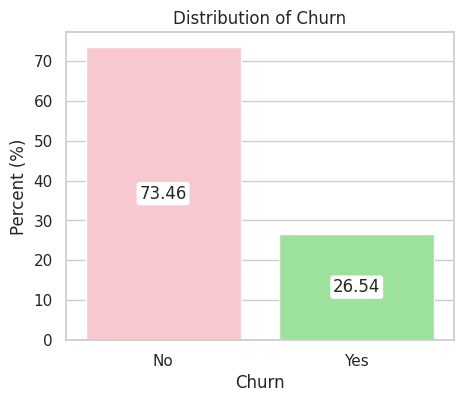

In [54]:
df_count = (df_churn['Churn'].value_counts(normalize=True).round(4) * 100).reset_index(name='Percent (%)')
bbox = {'boxstyle': 'round', 'facecolor': '#ffffff', 'linewidth': 0.3, 'pad': 0.15}
palette = {'Yes':'lightgreen', 'No':'pink'}
sns.set_palette("pastel")
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.barplot(data=df_count, x='Churn', y='Percent (%)', palette=palette)
ax.bar_label(ax.containers[0], label_type='center', bbox=bbox)
ax.bar_label(ax.containers[1], label_type='center', bbox=bbox)
ax.set_title('Distribution of Churn');
plt.show()

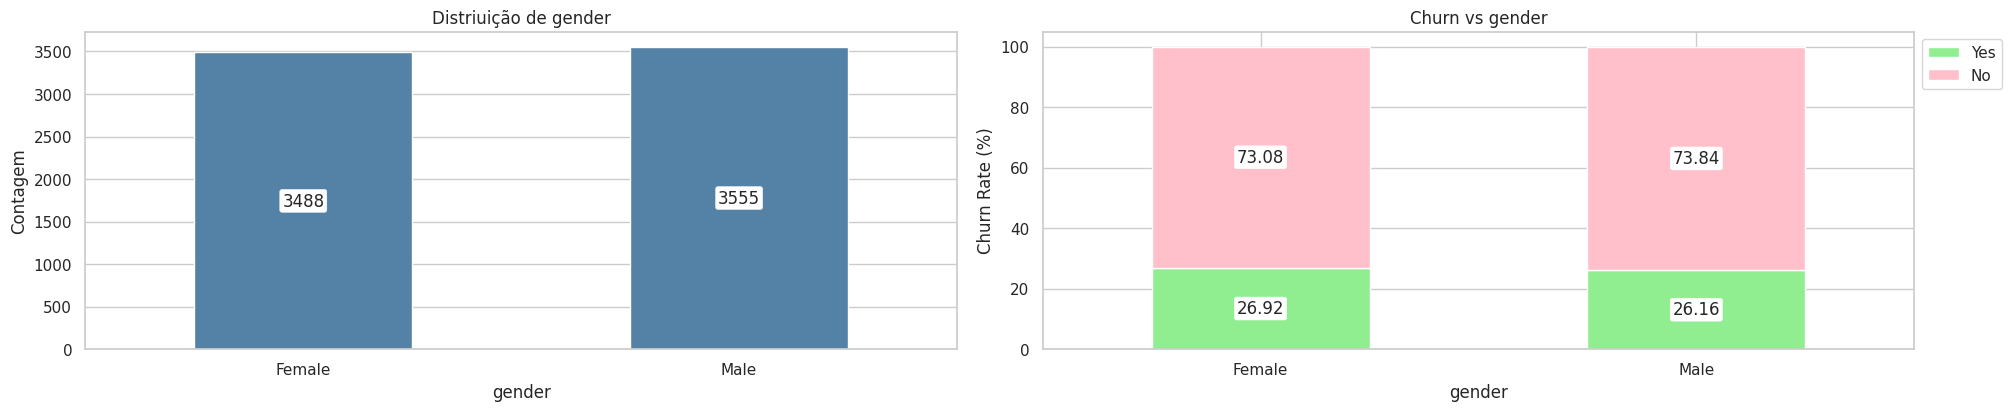

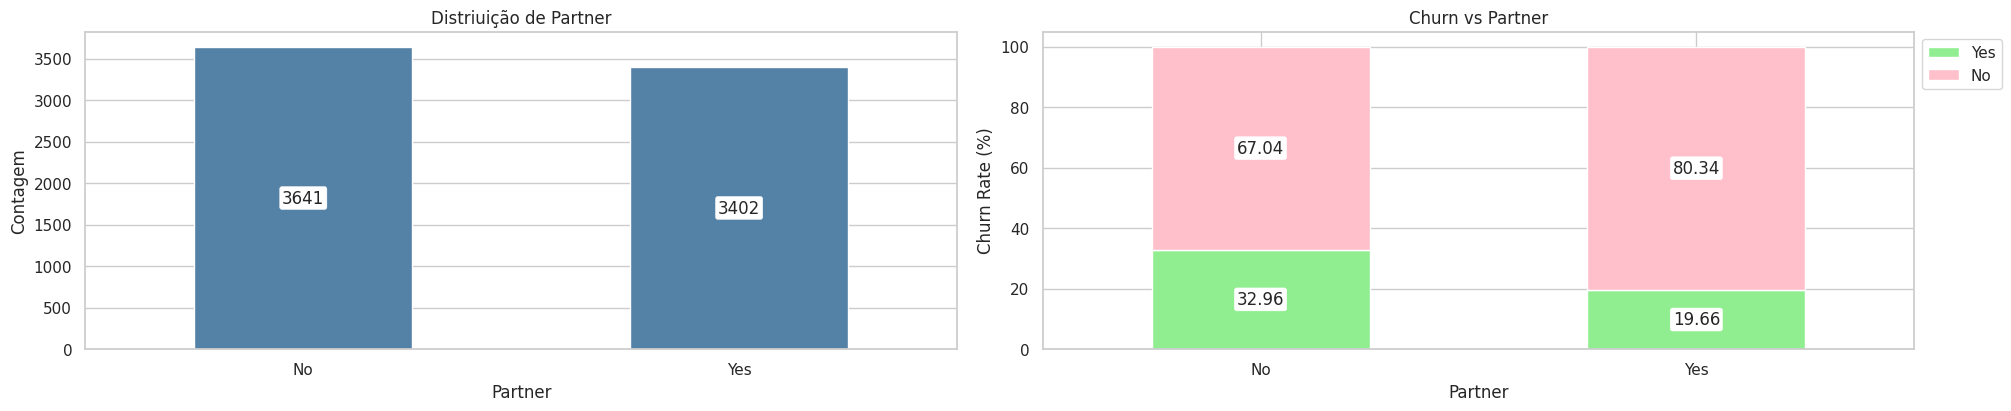

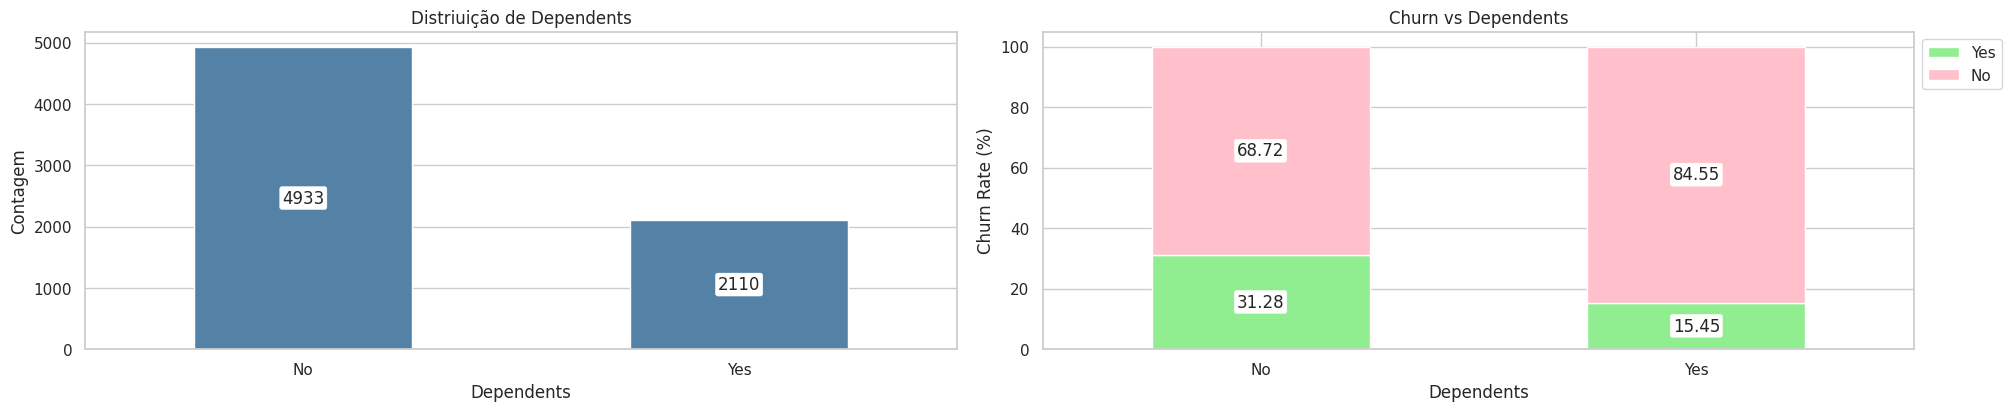

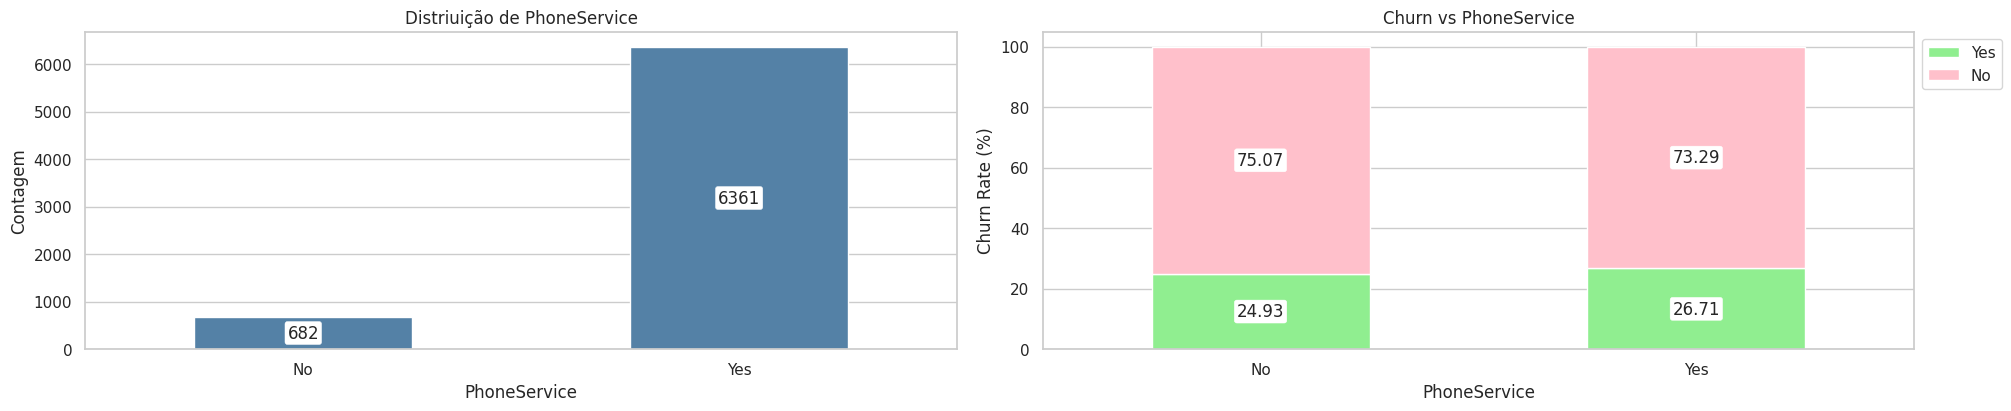

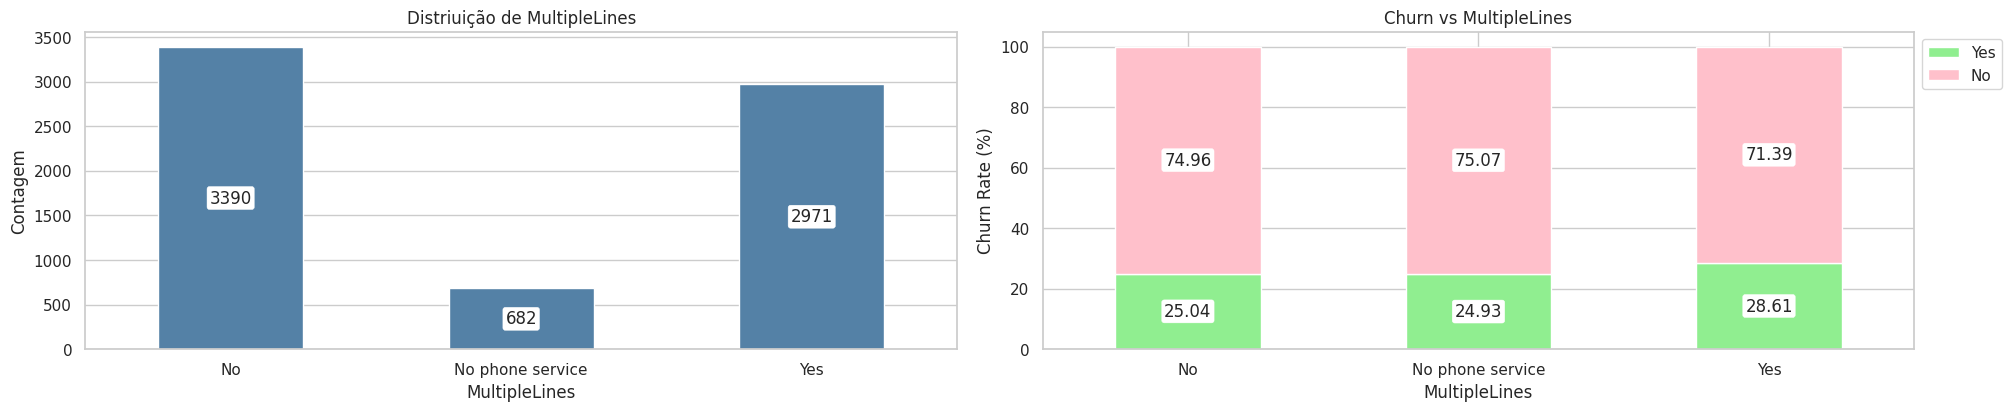

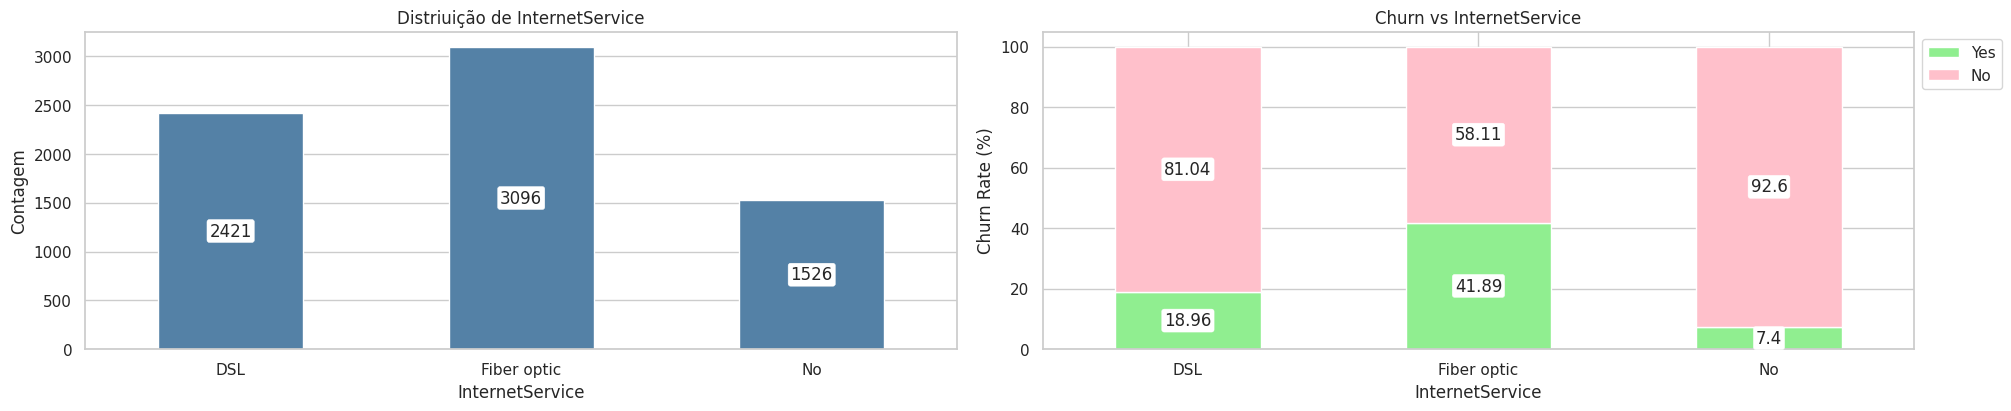

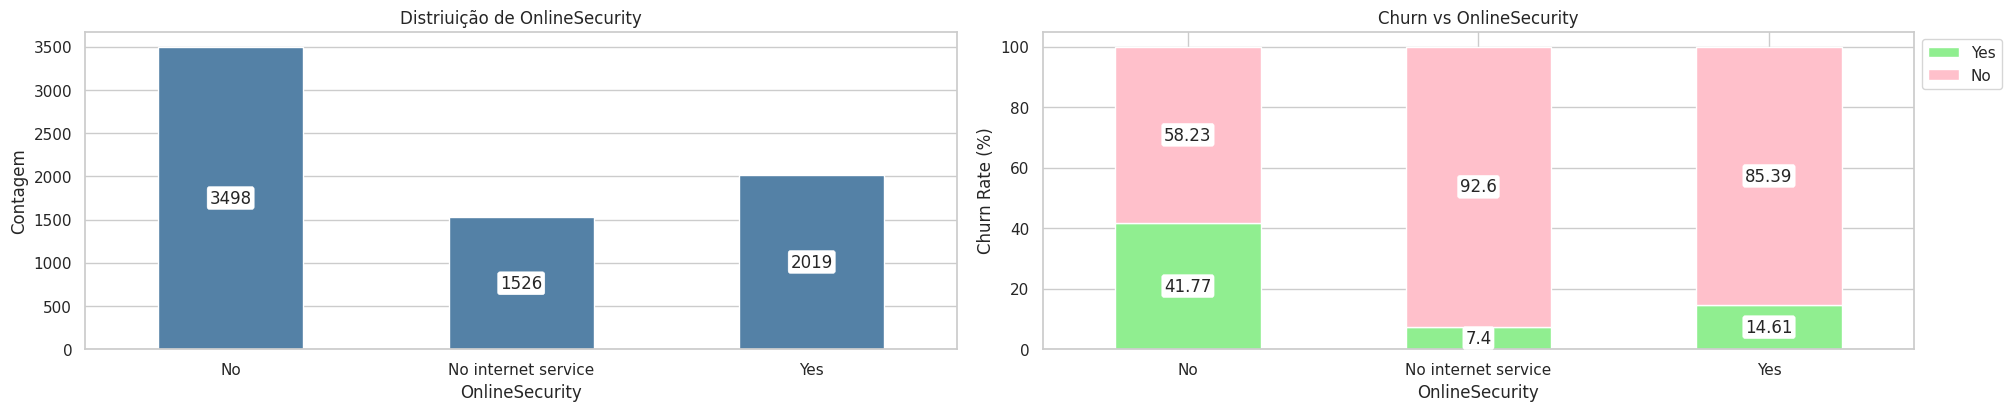

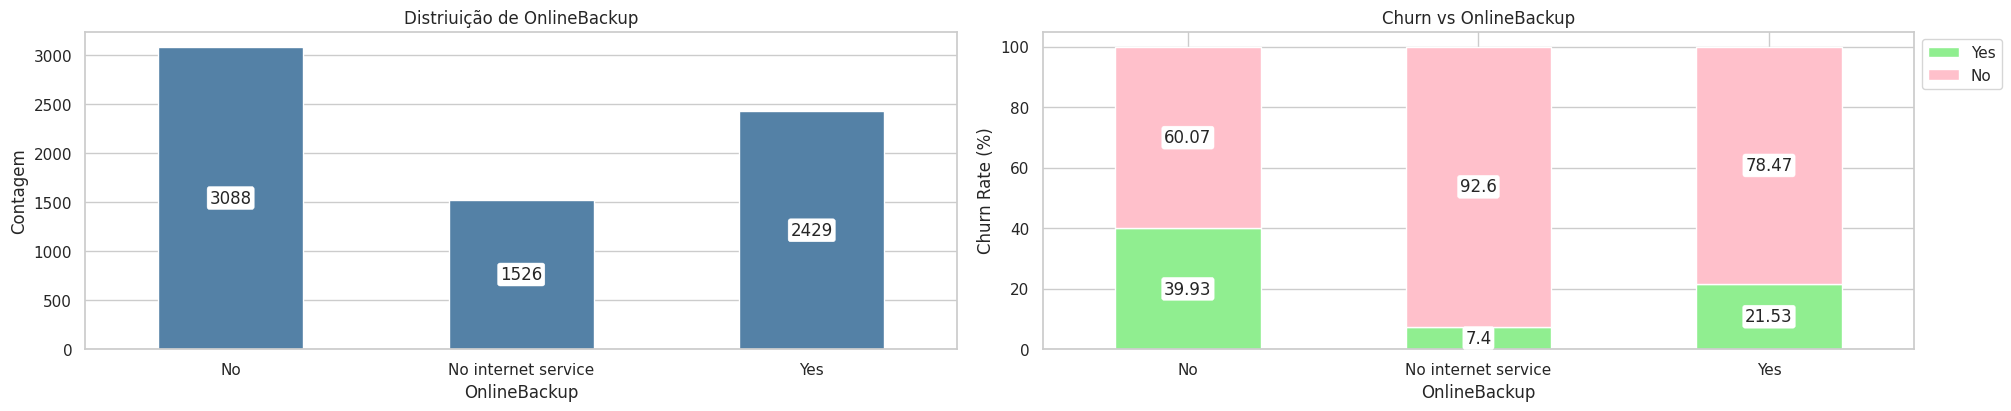

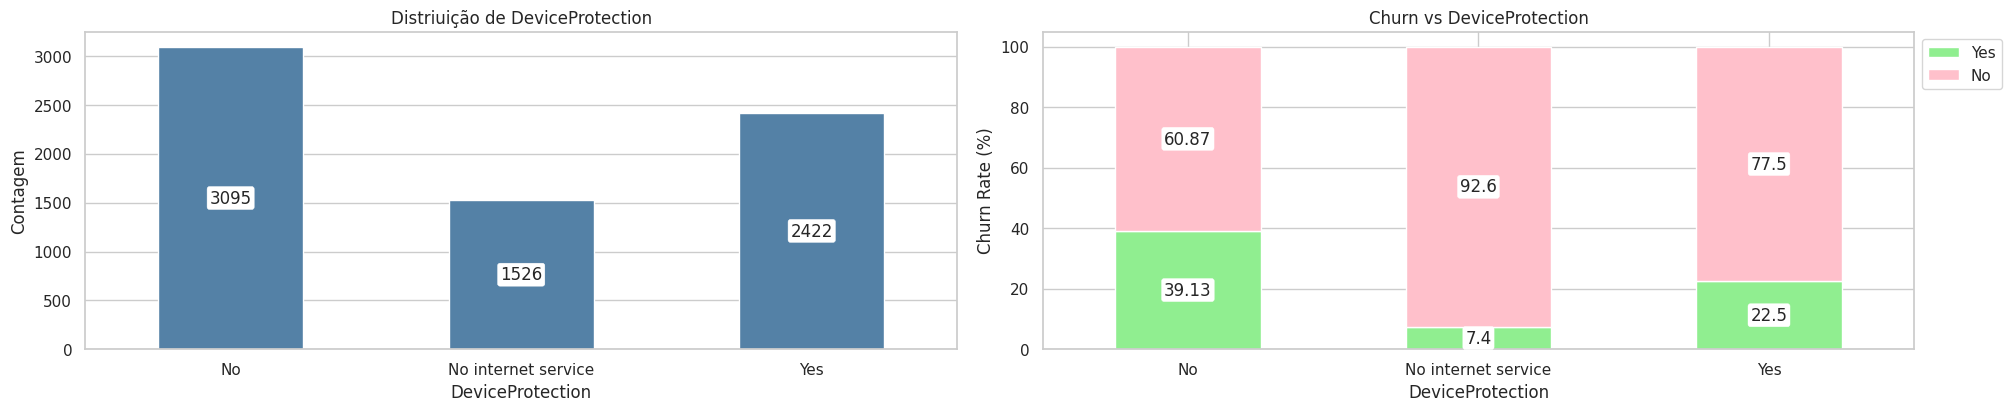

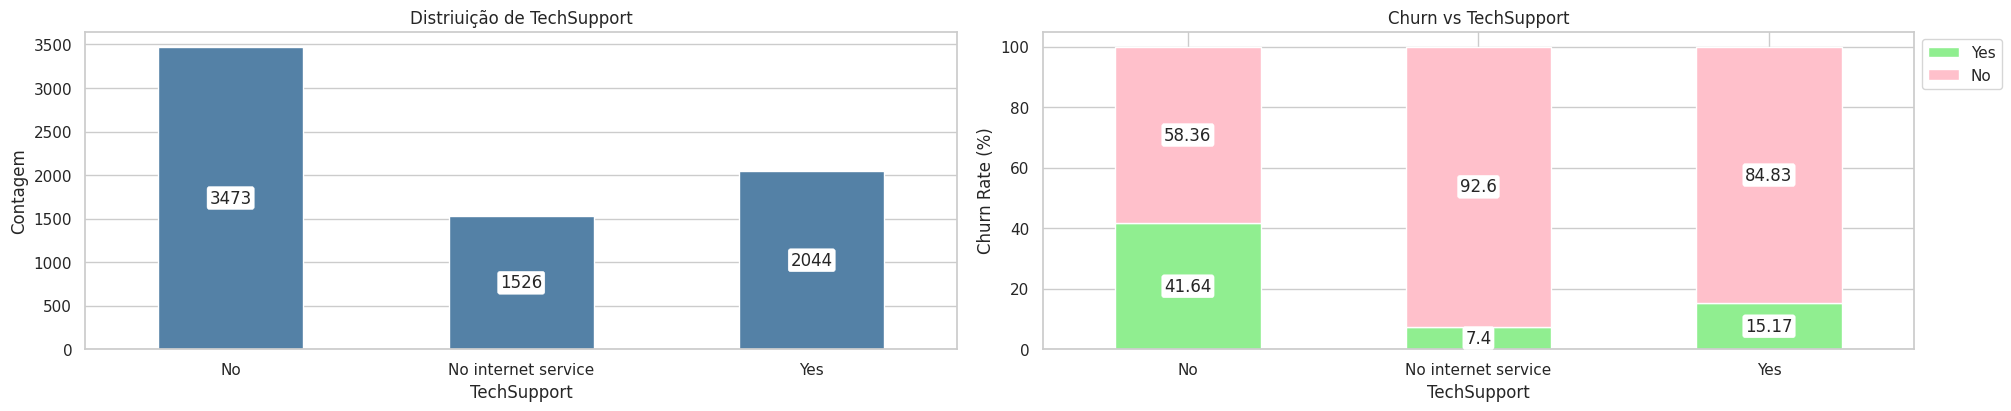

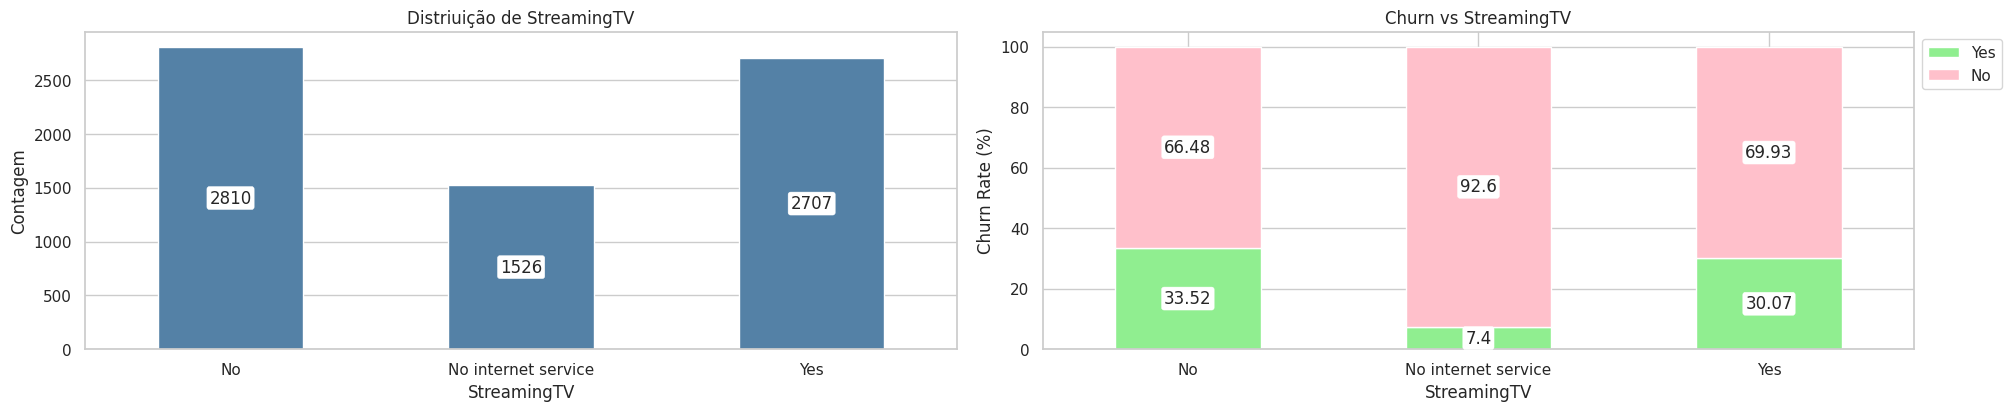

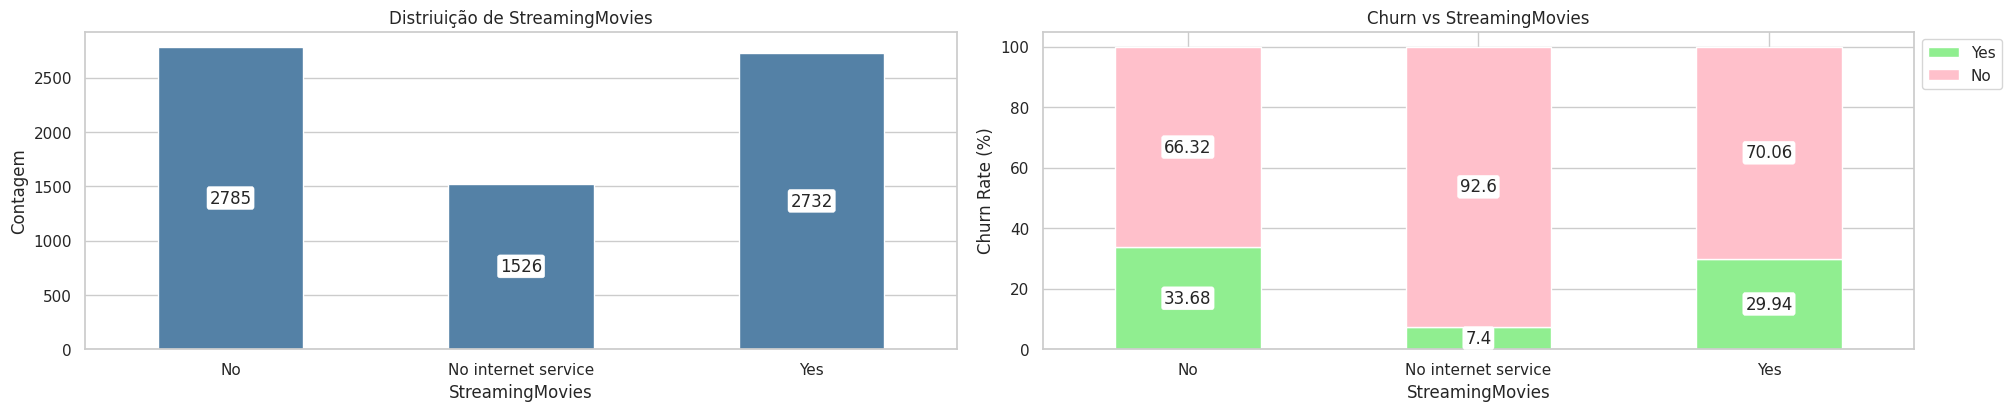

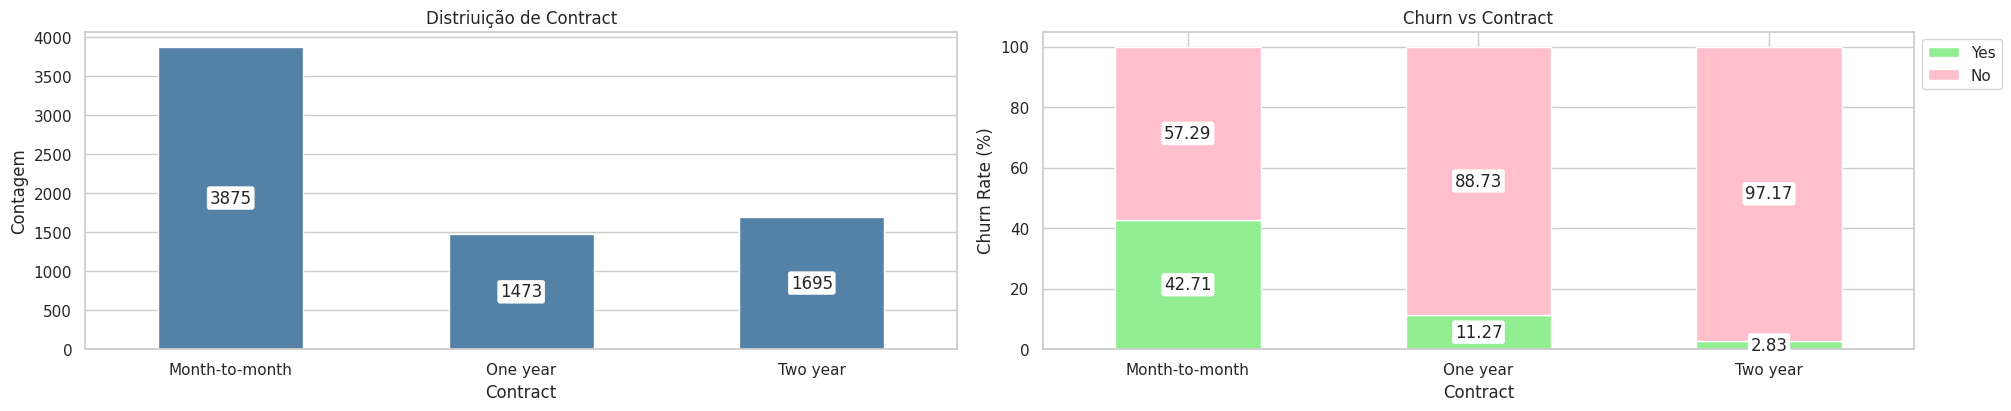

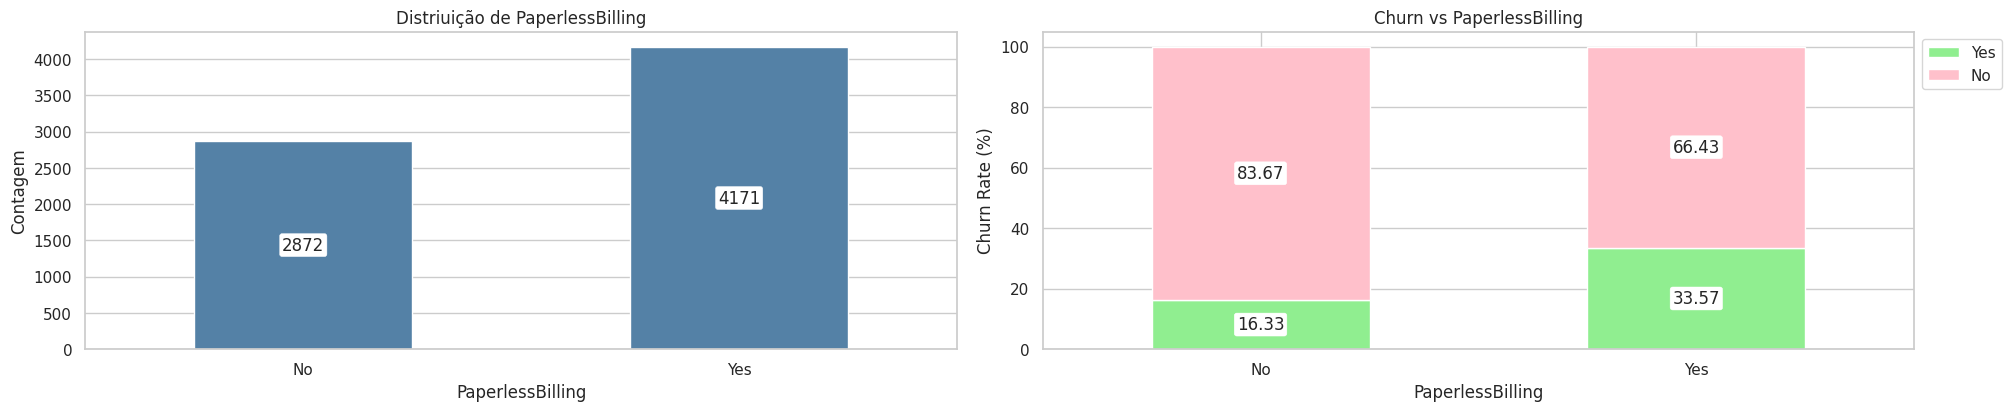

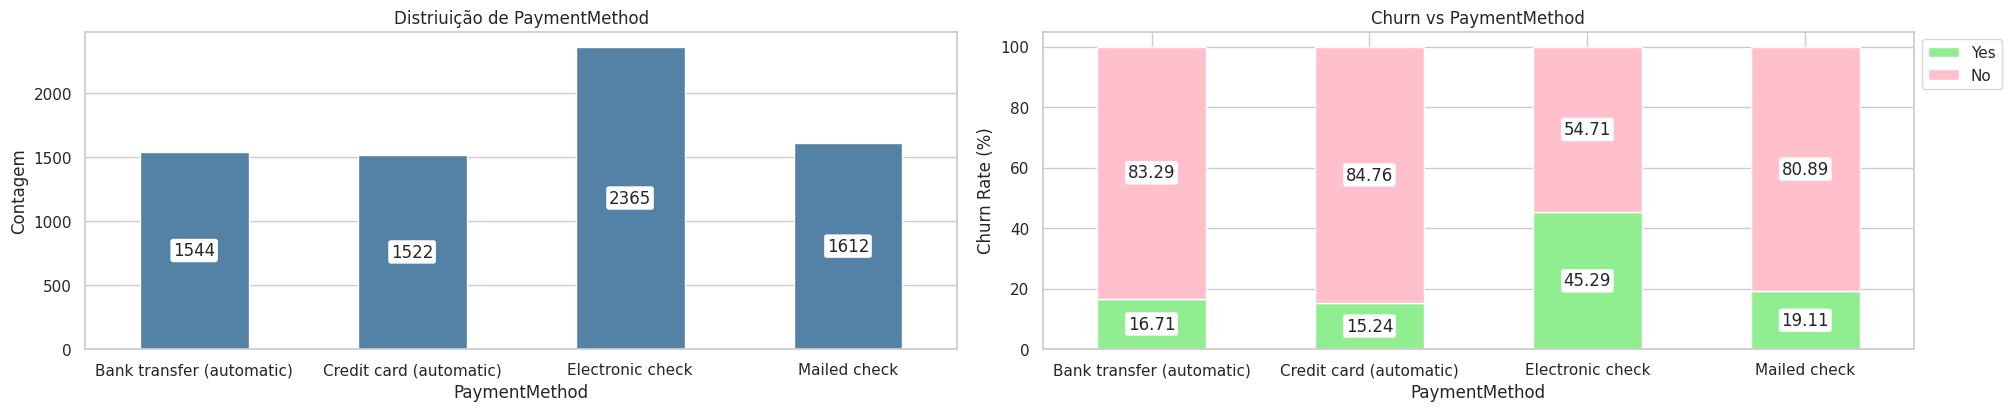

In [55]:
# Seleção das variáveis categórias

categorical_features = df_churn.select_dtypes(include=object).columns

def plot_categorical_column(df, col, figsize=(20, 4)):

    fig, ax = plt.subplots(1, 2, figsize=figsize, layout='constrained')

    df_percent = (df_churn.groupby([col, 'Churn']).size() / df_churn.groupby(col).size() * 100).unstack().round(2)[['Yes', 'No']]

    df_percent.plot(kind='bar', stacked=True, ax=ax[1], color=palette)
    for container in ax[1].containers:
        ax[1].bar_label(container, label_type='center', bbox=bbox)
    ax[1].set(title=f'Churn vs {col}', xlabel=col, ylabel='Churn Rate (%)')
    ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1));

    df_count = df[col].value_counts().reset_index(name='Contagem')

    sns.barplot(data=df_count, x=col, y='Contagem', ax=ax[0], color='steelblue', width=0.5, order=df_percent.index)
    ax[0].bar_label(ax[0].containers[0], label_type='center', bbox=bbox)
    ax[0].set(title=f'Distriuição de {col}', xlabel=col, ylabel='Contagem')

    plt.xticks(rotation=0)
    plt.show();

for col in categorical_features:
    if col != 'Churn':
      plot_categorical_column(df_churn, col)

## **2. Preparação de Dados**

A preparação de dados é o processo de preparar os dados a fim de adequá-los para etapas posteriores de processamento e análise. É importante que qualquer pré-processamento nos dados seja feita posteriormente a separação dos dados entre treino e teste para que na etapa de teste/validação do modelo, o conteúdo da base de teste seja completamente inédito. O pré-processamento adequado pode aumentar a eficácia de um modelo de forma relevante.

### **2.1) Separação do Dataset entre Treino e Teste**

Para que o modelo possa fazer operações matemáticas com as informações presentes no dataset, é necessário que converter as variáveis categórias para variáveis numéricas. Para isso, primeiramente, o dataset precisa ser dividido aleatoriamente entre treino e teste.

Com intuito de assegurar que a amostragem aleatória seja feita de maneira que garanta que cada classe é representata apropriadamente nos conjuntos de treino e teste, a separação deve ser feita com estratificação.

Para este projeto, como o dataset possui muitas variáveis categóricas binárias (Sim/Não), é possível fazer uma formatação inicial transformando-as em numéricas categóricas (1 e 0). Este tipo de pré-processamento pode ser feito no dataset como um todo, antes da separação entre treino e teste.


In [56]:
# Transformando variáveis binárias categórias em binárias numéricas

df_binary_features = ["gender","Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"]

for feature in df_binary_features:
  if feature == "gender":
    df_churn[feature] = df_churn[feature].map({'Female':1 ,'Male':0})
  else:
    df_churn[feature] = df_churn[feature].map({'Yes':1 ,'No':0})

df_churn.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,0,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,0,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,0,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,1,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


In [57]:
# Separação entre Treino e Teste

test_size = 0.20 # tamanho do conjunto de teste
seed = 5

X = df_churn.drop(columns=['Churn'])  # Features
y = df_churn['Churn'].copy() # Target


X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação


### **2.2) Enconding**

O segundo passo é converter as variáveis categóricas em numéricas através da técnica de Encoding. Como variáveis deste dataset são nominais, ou seja, não há hierarquia entre as categorias, a técnica escolhida foi a de One Hot Encoding, onde cada categoria é transformada em uma nova variável binária, conhecida como dummy variable.

Uma consequência associada ao processo de Enconding é o aumento do número das variáveis do dataset, que pode resultar no problema da dimensionalidade. A alta dimensionalidade da base pode gerar ruído para o aprendizado do modelo e dificultar sua capacidade de reconhecer padrões.

In [58]:
# One Hot Encoding

categorical_features_to_encode = ["MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaymentMethod"]

# Configurar o OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Aplicar o encoder às colunas categóricas das bases de teste e treino
X_train_encoded = encoder.fit_transform(X_train[categorical_features_to_encode])
X_test_encoded = encoder.transform(X_test[categorical_features_to_encode])

# Converter os resultados codificados em DataFrames
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_features_to_encode), index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_features_to_encode), index=X_test.index)

# Concatenar os resultados codificados com as colunas numéricas restantes
X_train_final = pd.concat([X_train, X_train_encoded_df], axis=1)
X_train_final.drop(categorical_features_to_encode, axis=1, inplace=True)

X_test_final = pd.concat([X_test, X_test_encoded_df], axis=1)
X_test_final.drop(categorical_features_to_encode, axis=1, inplace=True)


In [59]:
X_train_final

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
3031,1,1,1,0,50,1,1,71.05,3444.85,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4569,1,0,0,0,22,1,1,48.80,1054.60,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6636,1,0,1,1,10,1,0,70.30,676.15,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3067,0,0,0,0,6,1,1,84.40,556.35,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5769,1,0,1,1,71,1,1,109.00,7661.80,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2792,1,0,0,0,15,1,0,48.85,736.80,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6881,1,0,1,1,32,0,1,35.15,1051.05,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2906,1,0,1,1,6,1,1,48.80,297.35,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2823,0,0,1,0,39,1,1,20.45,790.00,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


### **2.2) Normalização**

A normalização e a padronização são processos de dimensionamento de recursos. Essas técnicas consistem na transformação dos valores numéricos das variáveis, que podem possuir diferentes escalas de grandeza, em um conjunto de dados com escala semelhante para que todos eles contribuam de forma semelhante na aprendizagem do modelo.

Esta estapa não é um processo obrigatório, mas pode impactar de forma positiva nos resultados ao evitar que valores maiores influenciem nas previsões.

Durante a modelagem, será feito testes com a base de dados normalizada e original dentro de pipelines para averiguar o impacto destas técnicas nas métricas de avaliação.


In [60]:
# Transformações que serão utilizadas
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

### **2.3) Redução de Dimensionalidade e Feature Selection**

Como mencionado anteriormente, a utilização da técnica de One Hot Encoding resulta no aumento da dimensionalidade do dataset.

Por isso, é necessário aplicar técnicas de como **Principal Component Analysis (PCA)** para combinação de variáveis em componentes principais, de menor número, e que tem a capacidade de descrever as características originais do dataset.

Outras técnicas a serem utilizada são as de Feature Selection, como o método **SelectKBest**, onde através cálculos estatísticos, são escolhidas as variáveis com maior influência na determinação da classe target para treinar o modelo.

In [61]:
# Redução de Dimensionalidade

pca = ('PCA', PCA())

# Feature Selection

feature_selection = ('KBest', SelectKBest(score_func=f_classif, k=8))

# Teste da aplicação do método SelectKBest no dataset pós-One Hot Encoding

Kbest = SelectKBest(score_func=f_classif, k=8)
X_Kbest = X_train_final.values
y_Kbest = y_train.values

# Executa a função de pontuação em (X, y) e obtém os atributos selecionados
fit = Kbest.fit(X_Kbest, y_Kbest)

# Reduz X para os atributos selecionados
features = fit.transform(X_Kbest)

# Resultados
print('\nNúmero original de atributos:', X_train_final.shape[1])
print('\nNúmero reduzido de atributos:', features.shape[1])

# Exibe os atributos orginais
print("\nAtributos Originais:", X_train_final.columns)

# Exibe as pontuações de cada atributos e os 4 escolhidas (com as pontuações mais altas)
np.set_printoptions(precision=3) # 3 casas decimais
print("\nScores dos Atributos Originais:", fit.scores_)
print("\nAtributos Selecionados:", Kbest.get_feature_names_out(input_features=X_train_final.columns))


Número original de atributos: 40

Número reduzido de atributos: 8

Atributos Originais: Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Con

É possível verificar, através dos gráficos de análise, que as variáveis/categorias selecionadas de fato possuem uma maior presença entre os cancelados.

## **3. Modelagem e treinamento:**

Nesta seção, realizaremos análises preliminares dos principais algoritmos de Classificação, utilizando pipelines para facilitar a avaliação e comparação dos modelos. O objetivo é identificar o algoritmo que apresenta o melhor desempenho para o problema em questão. Após a escolha do modelo mais adequado, serão feitos ajustes nos hiperparâmetros para melhorar a performance do modelo final.

### **3.1) Algoritmos**
- Selecione os algoritmos mais indicados para o problema e dataset escolhidos, justificando as suas escolhas.
- Há algum ajuste inicial para os hiperparâmetros?
- Há algum método avançado ou mais complexo que possa ser avaliado?
- Posso criar um comitê de modelos diferentes para o problema (ensembles)?


In [62]:
# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
bases.append(('logistic', LogisticRegression(max_iter=200)))
bases.append(('cart', DecisionTreeClassifier()))
bases.append(('svm', SVC()))

# Carregamento dos Algoritmos
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))
xgboost = ('XGB', xgb.XGBClassifier())

### **3.2) Métricas**

Para a avaliação da performance dos algoritmos de classificação, serão utilizadas duas métricas principais. A primeira delas é a **Acurácia**, que indica a taxa de predições corretas em relação ao total de predições feitas. Embora a acurácia seja útil para fornecer uma visão geral da performance do modelo, ela pode ser enganosa em problemas com classes desbalanceadas, como é o caso deste dataset, onde os cancelamentos (Churn) representam apenas 27% da população total. Em cenários como este, a acurácia pode mascarar o desempenho do modelo na detecção da classe minoritária (clientes com propensão ao churn), levando à escolha de um modelo que tenha um bom desempenho geral, mas que falhe em identificar os cancelamentos.

A variável target neste dataset é desbalanceada, com uma proporção de aproximadamente 7/3, sendo que a classe de cancelamento é significativamente menor. Nesse contexto, a principal prioridade é a detecção dos clientes com maior risco de churn, visto que o objetivo é gerar ações de retenção e mitigar as perdas. Portanto, é necessário considerar métricas que forneçam uma visão mais detalhada da capacidade do modelo de identificar corretamente os clientes com propensão ao cancelamento.

Em problemas como este, as métricas de **Precisão** e **Recall** são essenciais. A Sensibilidade (ou Recall) é importante, pois mede a capacidade do modelo de identificar corretamente os casos positivos (clientes que irão cancelar). No entanto, um modelo com altíssima sensibilidade pode acabar rotulando um grande número de clientes como propensos ao churn, gerando muitos falsos positivos. Por outro lado, se o foco for a Precisão, o modelo pode ser muito assertivo, mas com um número elevado de falsos negativos (clientes que irão cancelar, mas não são identificados pelo modelo).

Para balancear esses dois aspectos e evitar escolhas que favoreçam excessivamente um em detrimento do outro, será utilizada a métrica **F1-Score**, que combina a Precisão e o Recall em uma única medida, oferecendo uma média harmônica que é mais equilibrada e relevante para a avaliação do modelo em cenários de classes desbalanceadas.

Além disso, será aplicada a técnica de validação cruzada para garantir a robustez dos resultados. A validação cruzada divide o conjunto de dados de treinamento em várias subamostras, realizando múltiplos testes e calculando a média e o desvio padrão das métricas de avaliação em cada subdivisão. Isso assegura que o modelo seja avaliado de forma consistente e imparcial, minimizando o risco de overfitting e proporcionando uma visão mais precisa da performance geral do modelo em diferentes conjuntos de dados.

### **3.3) Pipeline com todas as variáveis**



In [63]:
# Dados de Treino

X_train = X_train_final.values
y_train = y_train.values

In [64]:
# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

np.random.seed(seed) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('XGB-orig', Pipeline([xgboost])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('XGB-norm', Pipeline([min_max_scaler, xgboost])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)



LR-orig: 0.806 (0.013)
KNN-orig: 0.763 (0.019)
CART-orig: 0.734 (0.009)
NB-orig: 0.691 (0.015)
SVM-orig: 0.735 (0.001)
Bag-orig: 0.780 (0.009)
RF-orig: 0.784 (0.010)
ET-orig: 0.769 (0.009)
Ada-orig: 0.802 (0.008)
GB-orig: 0.804 (0.011)
XGB-orig: 0.785 (0.013)
Vot-orig: 0.789 (0.011)
LR-norm: 0.806 (0.011)
KNN-norm: 0.758 (0.020)
CART-norm: 0.734 (0.014)
NB-norm: 0.692 (0.015)
SVM-norm: 0.800 (0.015)
Bag-norm: 0.785 (0.010)
RF-norm: 0.783 (0.009)
ET-norm: 0.766 (0.010)
Ada-norm: 0.802 (0.008)
GB-norm: 0.804 (0.011)
XGB-norm: 0.785 (0.013)
Vot-norm: 0.802 (0.016)


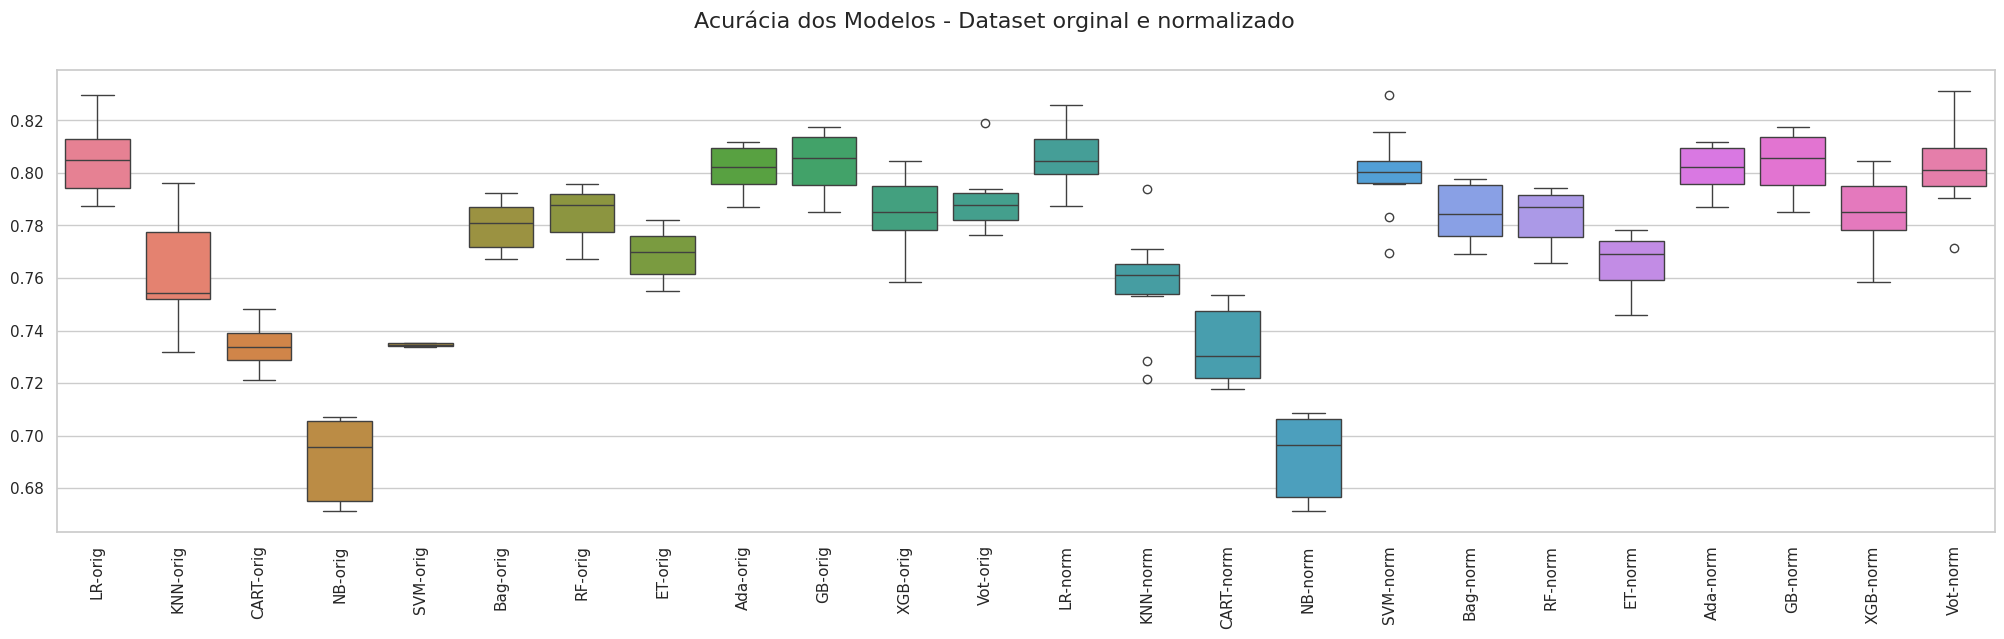

In [65]:
# Plotando os resultados
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(25, 6))
fig.suptitle('Acurácia dos Modelos - Dataset orginal e normalizado', fontsize=16)
sns.boxplot(data=results, ax=ax)
ax.set_xticklabels(names, rotation=90)
plt.show()

In [ ]:
# Executando os pipelines com a métrica F1-Score
scoring = 'f1'
results = []
names = []

for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

LR-orig: 0.601 (0.028)
KNN-orig: 0.498 (0.041)
CART-orig: 0.502 (0.022)
NB-orig: 0.593 (0.016)
SVM-orig: 0.000 (0.000)
Bag-orig: 0.558 (0.021)
RF-orig: 0.539 (0.026)
ET-orig: 0.511 (0.021)
Ada-orig: 0.586 (0.018)
GB-orig: 0.586 (0.023)
XGB-orig: 0.561 (0.032)
Vot-orig: 0.485 (0.030)
LR-norm: 0.601 (0.023)
KNN-norm: 0.528 (0.040)
CART-norm: 0.502 (0.022)
NB-norm: 0.593 (0.015)
SVM-norm: 0.570 (0.034)
Bag-norm: 0.543 (0.022)


In [ ]:
# Plotando os resultados
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(25, 6))
fig.suptitle('F1 dos Modelos - Dataset orginal e normalizado', fontsize=16)
sns.boxplot(data=results, ax=ax)
ax.set_xticklabels(names, rotation=90)
plt.show()

Modelos com melhores Acurácia Média:

* LR-Normalizado: 0.806 (0.01)
* LR-Padronizado: 0.806 (0.012)
* LR-Original: 0.806 (0.013)
* GB-Original: 0.804 (0.011)
* GB-Padronizado: 0.804 (0.011)

Modelos com melhores F1-Score Médio:

* LR-Padronizado:	0.603	(0.026)
* LR-Normalizado:	0.601	(0.023)
* LR-Original:	0.601	(0.028)
* NB-Original:	0.593	(0.016)
* NB-Padronizado:	0.593	(0.015)

### **3.3) Pipeline com redução de dimensionalidade**

In [ ]:
scoring = 'accuracy'

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset

pipelines = []
results = []
names = []

# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([pca, reg_log])))
pipelines.append(('KNN-orig', Pipeline([pca, knn])))
pipelines.append(('CART-orig', Pipeline([pca, cart])))
pipelines.append(('NB-orig', Pipeline([pca, naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([pca, svm])))
pipelines.append(('Bag-orig', Pipeline([pca, bagging])))
pipelines.append(('RF-orig', Pipeline([pca, random_forest])))
pipelines.append(('ET-orig', Pipeline([pca, extra_trees])))
pipelines.append(('Ada-orig', Pipeline([pca, adaboost])))
pipelines.append(('GB-orig', Pipeline([pca, gradient_boosting])))
pipelines.append(('XGB-orig', Pipeline([pca, xgboost])))
pipelines.append(('Vot-orig', Pipeline([pca, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, pca, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, pca, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, pca, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, pca, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, pca, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, pca, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, pca, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, pca, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, pca, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, pca, gradient_boosting])))
pipelines.append(('XGB-norm', Pipeline([min_max_scaler,pca, xgboost])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, pca, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


In [ ]:
# Plotando os resultados
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(25, 6))
fig.suptitle('Acurácia dos Modelos - Dataset orginal e normalizado - Redução de Dimensionalidade', fontsize=16)
sns.boxplot(data=results, ax=ax)
ax.set_xticklabels(names, rotation=90)
plt.show()

In [ ]:
# Executando os pipelines com a métrica F1-Score

scoring = 'f1'
results = []
names = []

for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [ ]:
# Plotando os resultados
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(25, 6))
fig.suptitle('F1 dos Modelos - Dataset orginal e normalizado - Redução de Dimensionalidade', fontsize=16)
sns.boxplot(data=results, ax=ax)
ax.set_xticklabels(names, rotation=90)
plt.show()

Modelos com melhores Acurácia Média:

* LR-Normalizado: 0.806 (0.011)
* LR-Padronizado: 0.806 (0.012)
* Vot-Padronizado: 0.805 (0.011)
* LR-Original: 0.805 (0.013)
* Vot-Normalizado: 0.804 (0.013)

Modelos com melhores F1-Score Médio:

* NB-Padronizado: 0.614 (0.028)
* NB-Normalizado: 0.611 (0.026)
* LR-Padronizado: 0.603 (0.027)
* LR-Normalizado: 0.601 (0.024)
* LR-Original: 0.598 (0.027)

### **3.4) Pipeline com redução de dimensionalidade e feature selection**

In [ ]:
scoring = 'accuracy'

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Feature Selection

feature_selection = ('KBest', SelectKBest(score_func=f_classif, k=8))

# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([pca, feature_selection, reg_log])))
pipelines.append(('KNN-orig', Pipeline([pca, feature_selection, knn])))
pipelines.append(('CART-orig', Pipeline([pca, feature_selection, cart])))
pipelines.append(('NB-orig', Pipeline([pca, feature_selection, naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([pca, feature_selection, svm])))
pipelines.append(('Bag-orig', Pipeline([pca, feature_selection, bagging])))
pipelines.append(('RF-orig', Pipeline([pca, feature_selection, random_forest])))
pipelines.append(('ET-orig', Pipeline([pca, feature_selection, extra_trees])))
pipelines.append(('Ada-orig', Pipeline([pca, feature_selection, adaboost])))
pipelines.append(('GB-orig', Pipeline([pca, feature_selection, gradient_boosting])))
pipelines.append(('XGB-orig', Pipeline([pca, feature_selection, xgboost])))
pipelines.append(('Vot-orig', Pipeline([pca, feature_selection, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, pca, feature_selection, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, pca, feature_selection, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, pca, feature_selection, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, pca, feature_selection, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, pca, feature_selection, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, pca, feature_selection, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, pca, feature_selection, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, pca, feature_selection, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, pca, feature_selection, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, pca, feature_selection, gradient_boosting])))
pipelines.append(('XGB-norm', Pipeline([min_max_scaler,pca, feature_selection, xgboost])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, pca, feature_selection, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [ ]:
# Plotando os resultados
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(25, 6))
fig.suptitle('Acurácia dos Modelos - Dataset original e normalizado - Redução de Dimensionalidade e Feature Selection', fontsize=16)
sns.boxplot(data=results, ax=ax)
ax.set_xticklabels(names, rotation=90)
plt.show()

In [ ]:
# Executando os pipelines com a métrica F1-Score

scoring = 'f1'
results = []
names = []

for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

In [ ]:
# Plotando os resultados
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(25, 6))
fig.suptitle('F1 dos Modelos - Dataset original e normalizado - Redução de Dimensionalidade e Feature Selection', fontsize=16)
sns.boxplot(data=results, ax=ax)
ax.set_xticklabels(names, rotation=90)
plt.show()

Modelos com melhores Acurácia Média:

* SVM-padr: 0.805 (0.011)
* Vot-padr: 0.803 (0.012)
* LR-padr: 0.804 (0.013)
* Ada-orig: 0.803 (0.014)
* LR-norm: 0.803 (0.015)

Modelos com melhores F1-Score Médio:

* NB-padr: 0.611 (0.027)
* NB-norm: 0.603 (0.026)
* LR-padr: 0.591 (0.030)
* LR-padr: 0.591 (0.030)
* Ada-orig: 0.590 (0.033)
* LR-norm: 0.588 (0.035)

### **3.5) Teste inicial**

A partir das métricas preliminares obtidas durante as análises iniciais dos algoritmo com o validação cruzada, o modelo foi construído utilizando o algoritmo de **Regressão** Logística, com **Redução de Dimensionalidade** e **Normalização** dos Dados.
A Regressão Logística é um modelo de classificação amplamente utilizado para problemas binários, que prevê a probabilidade de uma amostra pertencer a uma das duas classes possíveis. Apesar de sua simplicidade, é eficaz em problemas de classificação onde existe uma relação linear entre as variáveis independentes e a variável dependente. Este modelo se destacou entre os algoritmos testados, figurando entre as melhores métricas em todos os cenários avaliados. A acurácia alcançada pelo modelo foi satisfatória, mas a avaliação foi complementada por métricas como F1-Score, dado o desbalanceamento das classes e a importância de detectar corretamente os clientes propensos ao churn.

In [ ]:
# Finalização das bases de teste

X_test = X_test_final.values

# Definindo os componentes do pipeline
reg_log = ('LR', LogisticRegression())
pca = ('PCA', PCA())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())
pipeline = [('LR-norm', Pipeline([min_max_scaler, pca, reg_log]))]

# Preparação do modelo
model = Pipeline([min_max_scaler, pca, reg_log])
model.fit(X_train, y_train)

# Estimativa da acurácia no conjunto de teste

predictions = model.predict(X_test)
print("Acurácia: ", accuracy_score(y_test, predictions))
print("Precisão: ", precision_score(y_test, predictions))
print("Recall: ", recall_score(y_test, predictions))
print("F1: ", f1_score(y_test, predictions))

Os resultados obtidos pelo modelo com dados inéditos foram, por hora, satisfatórios e se aproximam do encontrado na fase de teste, indicando que não houve overfitting e nem underfitting.

### **3.6) Otimização de Hiperparâmetros**

Durante esta primeira fase de modelagem, os algoritmos foram testados utilizando parâmetros genéricos, sem otimização detalhada. No entanto, é possível melhorar a performance do modelo realizando ajustes mais finos nos hiperparâmetros. Para isso, será utilizado o GridSearchCV, um pacote que permite realizar uma busca exaustiva por meio de combinações de diferentes valores para os hiperparâmetros escolhidos. Essa abordagem ajudará a identificar a configuração ideal para os parâmetros do modelo, maximizando a performance e garantindo um melhor ajuste ao conjunto de dados.

A otimização dos hiperparâmetros visa explorar outras variáveis que podem melhorar a capacidade preditiva do modelo na identificação dos clientes com maior risco de churn. Serão feitas duas opções de tunning, uma baseada no Recall e outra no F1-Score.

In [ ]:
np.random.seed(seed) # definindo uma semente global para este bloco

scoring = 'recall'

# Definindo os componentes do pipeline
reg_log = ('LR', LogisticRegression())
pca = ('PCA', PCA())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())
pipeline = [('LR-norm', Pipeline([min_max_scaler, pca, reg_log]))]

param_grid = {
    'PCA__n_components': [3,5,7,9,13,15],
    'LR__class_weight': ['balanced',  None],
    'LR__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'LR__max_iter': [150,200,300,500],
    'LR__penalty': ['l1', 'l2', 'elasticnet', None],
    'LR__C': np.logspace(-4,4,4),
}

# Prepara e executa o GridSearchCV
for name, model in pipeline:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: LR-norm - Melhor: 0.830770 usando {'LR__C': 0.0001, 'LR__class_weight': 'balanced', 'LR__max_iter': 150, 'LR__penalty': 'l2', 'LR__solver': 'sag', 'PCA__n_components': 3}

In [ ]:
scoring = 'f1'

# Definindo os componentes do pipeline
reg_log = ('LR', LogisticRegression())
pca = ('PCA', PCA())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())
pipeline = [('LR-norm', Pipeline([min_max_scaler, pca, reg_log]))]

param_grid = {
    'PCA__n_components': [3,5,7,9,13,15],
    'LR__class_weight': ['balanced',  None],
    'LR__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'LR__max_iter': [150,200,300,500],
    'LR__penalty': ['l1', 'l2', 'elasticnet', None],
    'LR__C': np.logspace(-4,4,4),
}

# Prepara e executa o GridSearchCV
for name, model in pipeline:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

## **4) Avaliação de Resultados**

### **4.1) Teste com parâmetros para um F1-Score mais performático**

In [ ]:
# Finalização das bases de teste

X_test = X_test_final.values

# Definindo os componentes do pipeline
reg_log = ('LR', LogisticRegression(C=0.0001, max_iter=150, solver='newton-cg', penalty=None,class_weight='balanced'))
pca = ('PCA', PCA(n_components=9))
min_max_scaler = ('MinMaxScaler', MinMaxScaler())
pipeline = [('LR-norm', Pipeline([min_max_scaler, pca, reg_log]))]

# Preparação do modelo
model = Pipeline([min_max_scaler, pca, reg_log])
model.fit(X_train, y_train)

# Estimativa da acurácia no conjunto de teste

predictions = model.predict(X_test)
print("Acurácia: ", accuracy_score(y_test, predictions))
print("Precisão: ", precision_score(y_test, predictions))
print("Recall: ", recall_score(y_test, predictions))
print("F1: ", f1_score(y_test, predictions))


### **4.2) Teste com parâmetros para um Recall mais performático**

In [ ]:
# Finalização das bases de teste

X_test = X_test_final.values

# Definindo os componentes do pipeline
reg_log = ('LR', LogisticRegression(C=0.0001, max_iter=150, solver='sag', penalty='l2',class_weight='balanced'))
pca = ('PCA', PCA(n_components=3))
min_max_scaler = ('MinMaxScaler', MinMaxScaler())
pipeline = [('LR-norm', Pipeline([min_max_scaler, pca, reg_log]))]

# Preparação do modelo
model = Pipeline([min_max_scaler, pca, reg_log])
model.fit(X_train, y_train)

# Estimativa da acurácia no conjunto de teste

predictions = model.predict(X_test)
print("Acurácia: ", accuracy_score(y_test, predictions))
print("Precisão: ", precision_score(y_test, predictions))
print("Recall: ", recall_score(y_test, predictions))
print("F1: ", f1_score(y_test, predictions))

Como esperado, o modelo com maior Recall apresenta um F1-Score e uma Precisão menor. Isto porque, se o modelo for ajustado para aumentar o recall, ele irá rotular mais clientes como churn, o que pode aumentar os falsos positivos. Isso geralmente leva a uma queda na precisão, pois mais clientes não propensos ao churn podem ser erroneamente classificados como cancelamentos. Por isso, o modelo final escolhido é o de parâmetros otimizados para uma maior performance no Recall.

### **4.2) Avaliação do Modelo Escolhido**

In [ ]:
# Construção da Matrix de Confusão para avaliação de resultados

cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.show()

print(classification_report(y_test, predictions, labels=model.classes_))

Os resultados obtidos após o ajuste do modelo com a otimização dos hiperparâmetros refletem as métricas obtidas durante a fase de treino, indicando que não houve underfitting na etapa de teste e nem overfitting na etapa de treinamento. O modelo alcançou uma acurácia de 0,71, o que significa que 71% das predições foram corretas. No entanto, ao analisar métricas mais específicas, observamos que a precisão foi de 0,47, ou seja, 47% (340 dos 649) das entradas rotuladas como propensas ao cancelamento realmente cancelaram. Em contrapartida, o modelo obteve uma sensibilidade de 0,82, rotulando corretamente 82% (309 de 374) dos clientes que efetivamente realizaram o churn.

Os resultados de Recall são mais relevantes para o objetivo do modelo, que é fornecer insumos para campanhas de retenção. Considerando que o custo de aquisição de novos clientes é, em regra, mais alto do que os custos relacionados à retenção, o modelo mostra uma boa performance. No contexto desse problema específico, é preferível que o modelo rotule clientes do tipo não-churn como churn (falsos positivos), a fim de garantir que nenhum cliente com propensão ao cancelamento seja deixado de fora e não receba ações de retenção, a deixar de identificar possíveis cancelamentos.